In [1]:
import re
import os, glob
import pandas as pd
import numpy as np
import scipy.stats as st
import pingouin as pg
import matplotlib.pyplot as plt

import seaborn as sns
import psignifit as ps


/Users/dominik/miniconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
plt.rcParams.update({'font.size': 16})
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
data_path = '../2drdkx_n/behanalysis/selected/'

In [4]:
summary_a20 = pd.read_csv(os.path.join(data_path, "summary_a20.csv"))
summary_a45 = pd.read_csv(os.path.join(data_path, "summary_a45.csv"))
data_files  = glob.glob(os.path.join(data_path, 'a*'))

In [5]:
summary_a20.head()

,Unnamed: 0,time_taken,finished,stcoh1,stcoh2,acc_part2,handness,browser,resolution,age,birth,sex,residence,employment,language,nationality,student
0,0,44.815283,yes,0.132028,0.263955,83.796,right,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"1366,728",18.0,Spain,Female,United Kingdom,Unemployed (and job seeking),NaN,Spain,Yes
1,1,33.313283,yes,0.037313,0.081208,79.142,right,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4...,"1280,709",26.0,Lithuania,Male,Spain,Full-Time,Lithuanian,Lithuania,No
2,2,39.373500,yes,0.046708,0.129425,80.242,right,Mozilla/5.0 (X11; CrOS x86_64 13099.110.0) App...,"1366,720",27.0,Denmark,Male,Denmark,Full-Time,Danish,Denmark,No
3,3,31.026067,yes,0.085471,0.128092,80.196,right,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"1920,1040",18.0,Poland,Male,Poland,Part-Time,Polish,Poland,Yes
4,4,53.065417,yes,0.042722,0.076805,70.884,right,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:80...,"1252,667",38.0,Poland,Male,Poland,Full-Time,Polish,Poland,No


In [6]:
from utils import extract_name_pattern, extract_data_from_part2, \
                  compute_mean_sterr_from_vector, get_avg_conditions_part2, \
                  load_trial_data_part2

In [7]:
from utils import read_part1, read_part2, read_data_practise, read_data_from_2drdk

### Practise analysis

In [8]:
pract_acc_20 = []
pract_acc_45 = []
nr_acc_20 = []
nr_acc_45 = []
for fp in data_files:
    nr_, acc_, angle = read_data_practise(fp)
    if angle == 20:
        pract_acc_20.append(acc_)
        nr_acc_20.append(nr_)
    elif angle == 45:
        pract_acc_45.append(acc_)
        nr_acc_45.append(nr_)
    else:
        raise ValueError('angle not recognised: {}'.format(user_data['angle']))

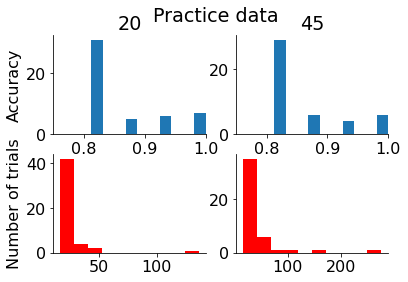

Angle 20
 Mean ACC: 0.86
 Median ACC: 0.81
 Mean NR TRIALS: 24.3
 Median NR TRIALS: 17.0
Angle 45
 Mean ACC: 0.86
 Median ACC: 0.81
 Mean NR TRIALS: 38.4
 Median NR TRIALS: 19.0


In [9]:
plt.subplot(221)
plt.hist(pract_acc_20)
plt.xlim([0.75, 1])
plt.ylabel('Accuracy')
plt.title('20')
plt.subplot(222)
plt.hist(pract_acc_45)
plt.xlim([0.75, 1])
plt.title('45')
plt.subplot(223)
plt.hist(nr_acc_20, color = 'r')
plt.ylabel('Number of trials')
plt.subplot(224)
plt.hist(nr_acc_45, color = 'r')
plt.suptitle('Practice data')
plt.show()

print('Angle 20')
print(' Mean ACC: {:.2f}'.format(np.mean(pract_acc_20)))
print(' Median ACC: {:.2f}'.format(np.median(pract_acc_20)))
print(' Mean NR TRIALS: {:.1f}'.format(np.mean(nr_acc_20)))
print(' Median NR TRIALS: {:.1f}'.format(np.median(nr_acc_20)))
print('Angle 45')
print(' Mean ACC: {:.2f}'.format(np.mean(pract_acc_45)))
print(' Median ACC: {:.2f}'.format(np.median(pract_acc_45)))
print(' Mean NR TRIALS: {:.1f}'.format(np.mean(nr_acc_45)))
print(' Median NR TRIALS: {:.1f}'.format(np.median(nr_acc_45)))


## Load data per angle

In [10]:
subj_20 = []
subj_45 = []
for fp in data_files:
    user_data = read_data_from_2drdk(fp)
    if user_data['angle'] == 20:
        subj_20.append(user_data)
    elif user_data['angle'] == 45:
        subj_45.append(user_data)
    else:
        raise ValueError('angle not recognised: {}'.format(user_data['angle']))

## Group analysis Part 1

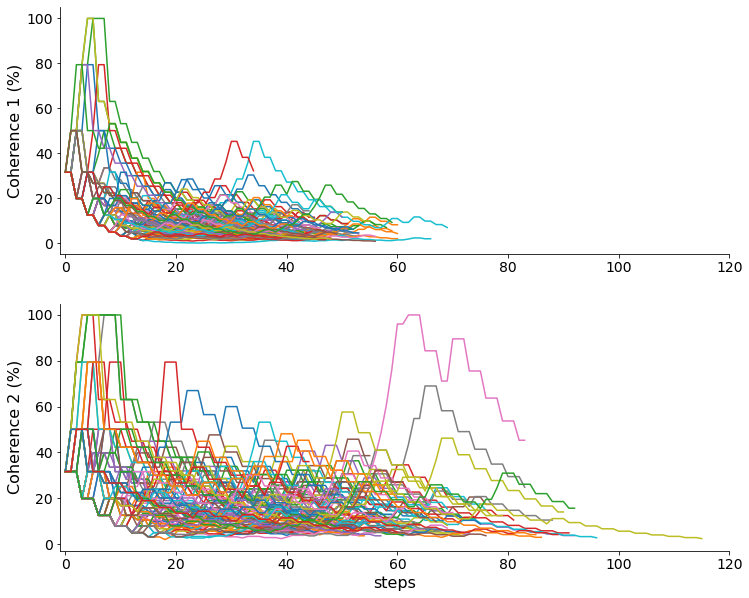

In [11]:
plt.figure(figsize=(12,10))
plt.subplot(211)
for i in range(len(subj_20)):
    plt.plot(range(len(subj_20[i]['part1']['stairs_c1'])), np.array(subj_20[i]['part1']['stairs_c1'])*100)
for i in range(len(subj_45)):
    plt.plot(range(len(subj_45[i]['part1']['stairs_c1'])), np.array(subj_45[i]['part1']['stairs_c1'])*100)
#plt.title('Staircase Coherence 1')
plt.ylabel('Coherence 1 (%)')
plt.xlim([-1, 120])
plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.subplot(212)
for i in range(len(subj_20)):
    plt.plot(range(len(subj_20[i]['part1']['stairs_c2'])), np.array(subj_20[i]['part1']['stairs_c2'])*100)
for i in range(len(subj_45)):
    plt.plot(range(len(subj_45[i]['part1']['stairs_c2'])), np.array(subj_45[i]['part1']['stairs_c2'])*100)
#plt.title('Staircase Coherence 2')
plt.xlabel('steps')
plt.ylabel('Coherence 2 (%)')
plt.xlim([-1, 120])
plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.savefig('staircase.png')
plt.show()

In [12]:
stairs_coh1_20 = []
stairs_coh2_20 = []
for i in range(len(subj_20)):
    stairs_coh1_20.append(subj_20[i]['part1']['stair_coh1'])
    stairs_coh2_20.append(subj_20[i]['part1']['stair_coh2'])
stairs_coh1_45 = []
stairs_coh2_45 = []
for i in range(len(subj_45)):
    stairs_coh1_45.append(subj_45[i]['part1']['stair_coh1'])
    stairs_coh2_45.append(subj_45[i]['part1']['stair_coh2'])

In [13]:
avg_coh1_20, ste_coh1_20 = compute_mean_sterr_from_vector(stairs_coh1_20)
avg_coh2_20, ste_coh2_20 = compute_mean_sterr_from_vector(stairs_coh2_20)
avg_coh1_45, ste_coh1_45 = compute_mean_sterr_from_vector(stairs_coh1_45)
avg_coh2_45, ste_coh2_45 = compute_mean_sterr_from_vector(stairs_coh2_45)

In [14]:
k2, p = st.normaltest(stairs_coh1_20 + stairs_coh1_45)
print("p_coh1 = {:g}".format(p))
k2, p = st.normaltest(stairs_coh2_20 + stairs_coh2_45)
print("p_coh2 = {:g}".format(p))

k2, p = st.normaltest(stairs_coh1_20)
print("p_coh1_20 = {:g}".format(p))
k2, p = st.normaltest(stairs_coh2_20)
print("p_coh2_20 = {:g}".format(p))

k2, p = st.normaltest(stairs_coh1_45)
print("p_coh1_45 = {:g}".format(p))
k2, p = st.normaltest(stairs_coh2_45)
print("p_coh2_45 = {:g}".format(p))


p_coh1 = 0.000982744
p_coh2 = 1.0265e-05
p_coh1_20 = 0.00246431
p_coh2_20 = 0.052716
p_coh1_45 = 0.103817
p_coh2_45 = 0.0029283


In [15]:
from utils import confidence_bootstrap

In [16]:
U , p_coh = st.mannwhitneyu(stairs_coh1_20 + stairs_coh1_45, stairs_coh2_20 + stairs_coh2_45)
print('p: ', p_coh)
print('U:', U, 'N:', len(stairs_coh1_20 + stairs_coh1_45))
confidence_bootstrap(stairs_coh1_20 + stairs_coh1_45, stairs_coh2_20 + stairs_coh2_45)

p:  5.3977284108808915e-15
U: 1534.0 N: 94


(0.06282888829787234, 0.09169618085106383)

In [17]:
U1 , p_coh1 = st.mannwhitneyu(stairs_coh1_20, stairs_coh1_45)
U2 , p_coh2 = st.mannwhitneyu(stairs_coh2_20, stairs_coh2_45)

In [18]:
print('COH1')
print('p: ', p_coh1)
print('U:', U1, 'N:', len(stairs_coh1_20), len(stairs_coh1_45))
print(confidence_bootstrap(stairs_coh1_20, stairs_coh1_45))
print('COH2')
print('p: ', p_coh2)
print('U:', U2, 'N:', len(stairs_coh2_20), len(stairs_coh2_45))
print(confidence_bootstrap(stairs_coh2_20, stairs_coh2_45))

COH1
p:  0.1838787101564766
U: 983.0 N: 49 45
(0.0013660092970521614, 0.026774584807256228)
COH2
p:  0.1281211457368845
U: 952.0 N: 49 45
(0.0020888714285713906, 0.04096730748299318)


In [19]:
from utils import plot_paired_value_lines, plot_barplot_two_means, plot_paired_barplots,\
                  plot_two_boxplots, plot_two_violin_plots

NameError: name 'sns' is not defined

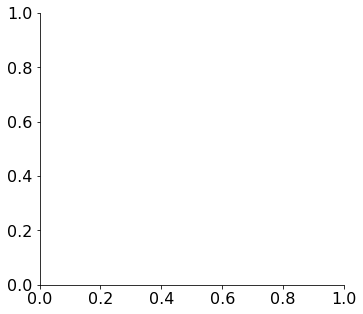

In [20]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plot_two_boxplots(100*np.array(stairs_coh1_20), 100*np.array(stairs_coh1_45), p_val = p_coh1, name1 = 'high', name2 = 'low', x_label = 'input correlation', col = 'lightblue', y_lim = [0,35])
plt.title('COH 1')
plt.ylabel('Coherence [%]')
plt.ylim([0,35])
plt.subplot(122)
plot_two_boxplots(100*np.array(stairs_coh2_20), 100*np.array(stairs_coh2_45), p_val = p_coh1, name1 = 'high', name2 = 'low', x_label = 'input correlation', col = 'pink', y_lim = [0,35])
plt.ylabel('')
plt.title('COH 2')
plt.savefig('compcohs_box.png')
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plot_barplot_two_means(100*avg_coh1_20, 100*ste_coh1_20, 100*avg_coh1_45, 100*ste_coh1_45, p_val = p_coh1, name1 = 20, name2 = 45, x_label = 'angle', bar_col = 'orange')
plt.title('COH 1')
plt.ylabel('Coherence [%]')
plt.ylim([0,18])
plt.subplot(122)
plot_barplot_two_means(100*avg_coh2_20, 100*ste_coh2_20, 100*avg_coh2_45, 100*ste_coh2_45, p_val = p_coh2, name1 = 20, name2 = 45, x_label = 'angle', bar_col = 'pink')
plt.ylim([0,18])
plt.title('COH 2')
plt.savefig('compcohs.png')
plt.show()

## Group analysis Part 2

### Control condition

In [ ]:
control_correct_20 = [subj_20[i]['part2']['corrects']['contr_m'] for i in range(len(subj_20))]
control_correct_45 = [subj_45[i]['part2']['corrects']['contr_m'] for i in range(len(subj_45))]
control_rts_20 = [subj_20[i]['part2']['rts']['contr_m'] for i in range(len(subj_20))]
control_rts_45 = [subj_45[i]['part2']['rts']['contr_m'] for i in range(len(subj_45))]

control_correct_20_s = [subj_20[i]['part2']['corrects']['contr_s'] for i in range(len(subj_20))]
control_correct_45_s = [subj_45[i]['part2']['corrects']['contr_s'] for i in range(len(subj_45))]
control_rts_20_s = [subj_20[i]['part2']['rts']['contr_s'] for i in range(len(subj_20))]
control_rts_45_s = [subj_45[i]['part2']['rts']['contr_s'] for i in range(len(subj_45))]

In [ ]:
print('Control, acc [20] = {:.3f} +- {:.3f}'.format(np.mean(control_correct_20), np.mean(control_correct_20_s)))
print('Control, acc [45] = {:.3f} +- {:.3f}'.format(np.mean(control_correct_45), np.mean(control_correct_45_s)))
print('Control, RT [20] = {:.3f} +- {:.3f}'.format(np.mean(control_rts_20), np.mean(control_rts_20_s)))
print('Control, RT [45] = {:.3f} +- {:.3f}'.format(np.mean(control_rts_45), np.mean(control_rts_45_s)))

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.hist(control_correct_20, color = 'orange')
plt.xlim([0.7, 1])
plt.title('20')
plt.ylabel('Accuracy')
plt.xlabel('ratio correct')
plt.subplot(222)
plt.hist(control_correct_45, color = 'orange')
plt.xlim([0.7, 1])
plt.title('45')
plt.xlabel('ratio correct')
plt.subplot(223)
plt.hist(control_rts_20, color = 'm')
plt.xlim([400, 1300])
plt.xlabel('time [ms]')
plt.ylabel('RT')
plt.subplot(224)
plt.hist(control_rts_45, color = 'm')
plt.xlim([400, 1300])
plt.xlabel('time [ms]')
plt.show()

### Accuracies

In [ ]:
correct_congr_20, correct_incon_20 = [], []
correct_congr_tr_20, correct_incon_tr_20 = [], []
for i in range(len(subj_20)):
    correct_congr_20.append(subj_20[i]['part2']['corrects']['cong_m'])
    correct_incon_20.append(subj_20[i]['part2']['corrects']['incong_m'])
    correct_congr_tr_20.append(subj_20[i]['part2']['corrects']['cong_true_m'])
    correct_incon_tr_20.append(subj_20[i]['part2']['corrects']['incong_true_m'])
correct_congr_45, correct_incon_45 = [], []
correct_congr_tr_45, correct_incon_tr_45 = [], []
for i in range(len(subj_45)):
    correct_congr_45.append(subj_45[i]['part2']['corrects']['cong_m'])
    correct_incon_45.append(subj_45[i]['part2']['corrects']['incong_m'])
    correct_congr_tr_45.append(subj_45[i]['part2']['corrects']['cong_true_m'])
    correct_incon_tr_45.append(subj_45[i]['part2']['corrects']['incong_true_m'])

In [ ]:
t_st_con_20, p_con_20 = st.ttest_rel(correct_congr_20, correct_congr_tr_20)
t_st_inc_20, p_inc_20 = st.ttest_rel(correct_incon_20, correct_incon_tr_20)
t_st_con_45, p_con_45 = st.ttest_rel(correct_congr_45, correct_congr_tr_45)
t_st_inc_45, p_inc_45 = st.ttest_rel(correct_incon_45, correct_incon_tr_45)

In [ ]:
avg_cong_20, ste_cong_20 = compute_mean_sterr_from_vector(correct_congr_20)
avg_contr_20, ste_contr_20 = compute_mean_sterr_from_vector(correct_congr_tr_20)

avg_inc_20, ste_inc_20 = compute_mean_sterr_from_vector(correct_incon_20)
avg_inctr_20, ste_inctr_20 = compute_mean_sterr_from_vector(correct_incon_tr_20)

avg_cong_45, ste_cong_45 = compute_mean_sterr_from_vector(correct_congr_45)
avg_contr_45, ste_contr_45 = compute_mean_sterr_from_vector(correct_congr_tr_45)

avg_inc_45, ste_inc_45 = compute_mean_sterr_from_vector(correct_incon_45)
avg_inctr_45, ste_inctr_45 = compute_mean_sterr_from_vector(correct_incon_tr_45)

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plot_paired_value_lines(correct_congr_20, correct_congr_tr_20, p_val = p_con_20, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 20$^o$')
#plot_barplot_two_means(avg_cong_20, ste_cong_20, avg_contr_20, ste_contr_20, p_val = p_con_20, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 20$^o$', bar_col = '#ffda4f')
plt.title('CONGRUENT')
plt.subplot(222)
plot_paired_value_lines(correct_incon_20, correct_incon_tr_20, p_val = p_inc_20, name1 = 'add', name2 = 'single axis')
#plot_barplot_two_means(avg_inc_20, ste_inc_20, avg_inctr_20, ste_inctr_20, p_val = p_inc_20, name1 = 'add', name2 = 'single axis', bar_col = '#dbdcff')
plt.title('INCONGRUENT')
plt.subplot(223)
plot_paired_value_lines(correct_congr_45, correct_congr_tr_45, p_val = p_con_45, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 45$^o$')
#plot_barplot_two_means(avg_cong_45, ste_cong_45, avg_contr_45, ste_contr_45, p_val = p_con_45, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 45$^o$', bar_col = '#ffda4f')
plt.subplot(224)
plot_paired_value_lines(correct_incon_45, correct_incon_tr_45, p_val = p_inc_45, name1 = 'add', name2 = 'single axis')
#plot_barplot_two_means(avg_inc_45, ste_inc_45, avg_inctr_45, ste_inctr_45, p_val = p_inc_45, name1 = 'add', name2 = 'single axis', bar_col = '#dbdcff')
plt.suptitle('Accuracies')
plt.savefig('accuracies.png')
plt.show()

In [ ]:
(np.mean(correct_congr_tr_20) + np.mean(correct_congr_tr_45)) / 2

In [ ]:
(np.mean(correct_incon_tr_20) + np.mean(correct_incon_tr_45)) / 2

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(top = 0.95, hspace = 0.2, wspace = 0.1)
plt.subplot(221)
plot_two_violin_plots(correct_congr_20, correct_congr_tr_20, p_val = p_con_20,
                      name1 = 'double', name2 = 'single', y_label = 'Accuracy',
                      col = '#FFE0A1', y_lim = [0.42, 1], lines = 2, x_label = ' ', p_pos = 1.01)
plt.title(' ', fontdict={'size':14})
ax = plt.subplot(222)
plot_two_violin_plots(correct_incon_20, correct_incon_tr_20, p_val = p_inc_20,
                      name1 = 'double', name2 = 'single', y_label = ' ',
                      col = '#9DE6FF', y_lim = [0.42, 1], lines = 2, x_label = ' ', p_pos = 1.01)
plt.yticks([])
ax.yaxis.set_label_position("right")
ax.set_ylabel('high input corr. (20$^\mathrm{o}$)', rotation=270)
plt.title(' ', fontdict={'size':14})
plt.subplot(223)
plot_two_violin_plots(correct_congr_45, correct_congr_tr_45, p_val = p_con_45, p_pos = 1.01,
                      name1 = 'double', name2 = 'single', y_label = 'Accuracy',
                      col = '#FFCF66', y_lim = [0.42, 1], lines = 2, x_label = 'number of sources')
ax = plt.subplot(224)
plot_two_violin_plots(correct_incon_45, correct_incon_tr_45, p_val = p_inc_45, p_pos = 1.01,
                      name1 = 'double', name2 = 'single', y_label = '',
                      col = '#63D5FF', y_lim = [0.42, 1], lines = 2, x_label = 'number of sources')
ax.yaxis.set_label_position("right")
ax.set_ylabel('low input corr. (45$^\mathrm{o}$)', rotation=270)
plt.savefig('accuracies_violin.svg')
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plot_paired_barplots(correct_congr_20, correct_congr_tr_20, p_val = None,
                      name1 = '', name2 = '', y_label = 'Accuracy',
                      bar_col = '#fb6220', y_lim = [0.4, 1], x_label = ' ', p_pos=1.01)
plt.title('Congruent')
ax = plt.subplot(222)
plot_paired_barplots(correct_incon_20, correct_incon_tr_20, p_val = None,
                      name1 = '', name2 = '', y_label = ' ',
                      bar_col = '#aaacff', y_lim = [0.4, 1], x_label = ' ', p_pos=1.01)
ax.yaxis.set_label_position("right")
ax.set_ylabel('high input corr. (20$^\mathrm{o}$)', rotation=270)
plt.title('Incongruent')
plt.subplot(223)
plot_paired_barplots(correct_congr_45, correct_congr_tr_45, p_val = None,
                      name1 = 'double', name2 = 'single', y_label = 'Accuracy',
                      bar_col = '#df4e0f', y_lim = [0.4, 1], x_label = '# of sources', p_pos=1.01)
ax = plt.subplot(224)
plot_paired_barplots(correct_incon_45, correct_incon_tr_45, p_val = None,
                      name1 = 'double', name2 = 'single', y_label = ' ',
                      bar_col = '#6467f6', y_lim = [0.4, 1], x_label = '# of sources', p_pos=1.01)
ax.yaxis.set_label_position("right")
ax.set_ylabel('low input corr. (45$^\mathrm{o}$)', rotation=270)
plt.tight_layout()
plt.savefig('accuracies_bars.png')
plt.show()

In [ ]:
plt.figure(figsize=(2,4))
for diff in (np.array(correct_congr_tr_45)-np.array(correct_congr_45)):
    plt.plot([0], diff*100, 'ko')
    
plt.bar([0], (np.mean(correct_congr_tr_45)-np.mean(correct_congr_45))*100)

In [ ]:
t_st_con, p_con = st.ttest_ind(correct_congr_20, correct_congr_45)
t_st_inc, p_inc = st.ttest_ind(correct_incon_20, correct_incon_45)
t_st_con_t, p_con_t = st.ttest_ind(correct_congr_tr_20, correct_congr_tr_45)
t_st_inc_t, p_inc_t = st.ttest_ind(correct_incon_tr_20, correct_incon_tr_45)

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plot_barplot_two_means(avg_cong_20, ste_cong_20, avg_cong_45, ste_cong_45, p_val = p_con, name1 = '20', name2 = '45', y_label = 'Additive', bar_col = '#f6c9b9', y_lim = (0.6, 0.9))
plt.title('CONGRUENT')
plt.subplot(222)
plot_barplot_two_means(avg_inc_20, ste_inc_20, avg_inc_45, ste_inc_45, p_val = p_inc, name1 = '20', name2 = '45', bar_col = '#a2697d', y_lim = (0.6, 0.9))
plt.title('INCONGRUENT')
plt.subplot(223)
plot_barplot_two_means(avg_contr_20, ste_contr_20, avg_contr_45, ste_contr_45, p_val = p_con_t, name1 = '20', name2 = '45', y_label = 'Single axis', bar_col = '#f6c9b9', y_lim = (0.6, 0.9))
plt.subplot(224)
plot_barplot_two_means(avg_inctr_20, ste_inctr_20, avg_inctr_45, ste_inctr_45, p_val = p_inc_t, name1 = '20', name2 = '45', bar_col = '#a2697d', y_lim = (0.6, 0.9))
plt.suptitle('Accuracies')
plt.savefig('accuracies_angles.png')
plt.show()

In [ ]:
from statsmodels.stats.anova import AnovaRM

In [ ]:
df_anova20 = pd.DataFrame(
    {'pid': np.tile(np.tile(np.arange(len(correct_congr_20)), 2), 2),
    'axis': np.concatenate((np.zeros(len(correct_congr_20)), np.ones(len(correct_congr_tr_20)), np.zeros(len(correct_incon_20)), np.ones(len(correct_incon_tr_20)))),
    'congr': np.concatenate((np.zeros(len(correct_congr_20)+len(correct_congr_tr_20)), np.ones(len(correct_incon_20)+len(correct_incon_tr_20)))),
    'correct': np.concatenate((correct_congr_20, correct_congr_tr_20, correct_incon_20, correct_incon_tr_20)) })

In [ ]:
print('Angle: 20 (acc)')
print(AnovaRM(data = df_anova20, depvar='correct', subject='pid', within=['axis', 'congr']).fit())

In [ ]:
df_anova45 = pd.DataFrame(
    {'pid': np.tile(np.tile(np.arange(len(correct_congr_45)), 2), 2),
    'axis': np.concatenate((np.zeros(len(correct_congr_45)), np.ones(len(correct_congr_tr_45)), np.zeros(len(correct_incon_45)), np.ones(len(correct_incon_tr_45)))),
    'congr': np.concatenate((np.zeros(len(correct_congr_45)+len(correct_congr_tr_45)), np.ones(len(correct_incon_45)+len(correct_incon_tr_45)))),
    'correct': np.concatenate((correct_congr_45, correct_congr_tr_45, correct_incon_45, correct_incon_tr_45)) })
print('Angle: 45 (acc)')
print(AnovaRM(data = df_anova45, depvar='correct', subject='pid', within=['axis', 'congr']).fit())

In [ ]:
posthocs = pg.pairwise_ttests(data = df_anova20, dv='correct', subject='pid', within=['axis', 'congr'])
posthocs

In [ ]:
posthocs = pg.pairwise_ttests(data = df_anova45, dv='correct', subject='pid', within=['axis', 'congr'])
posthocs

In [ ]:
df_anova45.pid = df_anova45.pid + max(df_anova20.pid)+1
df_anova_all = pd.concat((df_anova20, df_anova45))
df_anova_all['angle'] = [20]*df_anova20.shape[0] + [45]*df_anova45.shape[0]

In [ ]:
jaspdf = {'pid': list(range(len(correct_congr_20) + len(correct_congr_45))),
 'cong_2':correct_congr_20 + correct_congr_45,
 'cong_1':correct_congr_tr_20 + correct_congr_tr_45,
 'inc_2':correct_incon_20 + correct_incon_45,
 'inc_1':correct_incon_tr_20 + correct_incon_tr_45,
 'angle':len(correct_congr_20)*[20]+len(correct_congr_45)*[45]}
jaspdf = pd.DataFrame(jaspdf)
jaspdf.to_csv("acc_jasp.csv")

### RTs

In [ ]:
rt_congr_20, rt_incon_20 = [], []
rt_congr_tr_20, rt_incon_tr_20 = [], []
for i in range(len(subj_20)):
    rt_congr_20.append(subj_20[i]['part2']['rts']['cong_m'])
    rt_incon_20.append(subj_20[i]['part2']['rts']['incong_m'])
    rt_congr_tr_20.append(subj_20[i]['part2']['rts']['cong_true_m'])
    rt_incon_tr_20.append(subj_20[i]['part2']['rts']['incong_true_m'])
rt_congr_45, rt_incon_45 = [], []
rt_congr_tr_45, rt_incon_tr_45 = [], []
for i in range(len(subj_45)):
    rt_congr_45.append(subj_45[i]['part2']['rts']['cong_m'])
    rt_incon_45.append(subj_45[i]['part2']['rts']['incong_m'])
    rt_congr_tr_45.append(subj_20[i]['part2']['rts']['cong_true_m'])
    rt_incon_tr_45.append(subj_20[i]['part2']['rts']['incong_true_m'])

In [ ]:
t_st_con_20, p_con_20 = st.ttest_rel(rt_congr_20, rt_congr_tr_20)
t_st_inc_20, p_inc_20 = st.ttest_rel(rt_incon_20, rt_incon_tr_20)
t_st_con_45, p_con_45 = st.ttest_rel(rt_congr_45, rt_congr_tr_45)
t_st_inc_45, p_inc_45 = st.ttest_rel(rt_incon_45, rt_incon_tr_45)

In [ ]:
avg_cong_20, ste_cong_20 = compute_mean_sterr_from_vector(rt_congr_20)
avg_contr_20, ste_contr_20 = compute_mean_sterr_from_vector(rt_congr_tr_20)

avg_inc_20, ste_inc_20 = compute_mean_sterr_from_vector(rt_incon_20)
avg_inctr_20, ste_inctr_20 = compute_mean_sterr_from_vector(rt_incon_tr_20)

avg_cong_45, ste_cong_45 = compute_mean_sterr_from_vector(rt_congr_45)
avg_contr_45, ste_contr_45 = compute_mean_sterr_from_vector(rt_congr_tr_45)

avg_inc_45, ste_inc_45 = compute_mean_sterr_from_vector(rt_incon_45)
avg_inctr_45, ste_inctr_45 = compute_mean_sterr_from_vector(rt_incon_tr_45)

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plot_paired_value_lines(rt_congr_20, rt_congr_tr_20, p_val = p_con_20, name1 = 'add', name2 = 'single axis', y_lim = [450, 2250], y_label = 'Angle: 20$^o$')
#plot_barplot_two_means(avg_cong_20, ste_cong_20, avg_contr_20, ste_contr_20, p_val = p_con_20, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 20$^o$', bar_col = '#ffda4f')
plt.title('CONGRUENT')
plt.subplot(222)
plot_paired_value_lines(rt_incon_20, rt_incon_tr_20, p_val = p_inc_20, name1 = 'add', name2 = 'single axis', y_lim = [450, 2250])
#plot_barplot_two_means(avg_inc_20, ste_inc_20, avg_inctr_20, ste_inctr_20, p_val = p_inc_20, name1 = 'add', name2 = 'single axis', bar_col = '#dbdcff')
plt.title('INCONGRUENT')
plt.subplot(223)
plot_paired_value_lines(rt_congr_45, rt_congr_tr_45, p_val = p_con_45, name1 = 'add', name2 = 'single axis', y_lim = [450, 2250], y_label = 'Angle: 45$^o$')
#plot_barplot_two_means(avg_cong_45, ste_cong_45, avg_contr_45, ste_contr_45, p_val = p_con_45, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 45$^o$', bar_col = '#ffda4f')
plt.subplot(224)
plot_paired_value_lines(rt_incon_45, rt_incon_tr_45, p_val = p_inc_45, name1 = 'add', name2 = 'single axis',  y_lim = [450, 2250])
#plot_barplot_two_means(avg_inc_45, ste_inc_45, avg_inctr_45, ste_inctr_45, p_val = p_inc_45, name1 = 'add', name2 = 'single axis', bar_col = '#dbdcff')
plt.suptitle('RTs')
plt.savefig('rts.png')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(top = 0.95, hspace = 0.2, wspace = 0.1)
plt.subplot(221)
plot_two_violin_plots(rt_congr_20, rt_congr_tr_20, p_val = p_con_20,
                      name1 = 'double', name2 = 'single', y_label = 'RT [ms]',
                      col = '#FFE0A1', y_lim = (450, 2400), lines = 2, x_label = ' ', p_pos = 2350)
plt.title(' ', fontdict={'size':14})
ax = plt.subplot(222)
plot_two_violin_plots(rt_incon_20, rt_incon_tr_20, p_val = p_inc_20,
                      name1 = 'double', name2 = 'single', y_label = ' ',
                      col = '#9DE6FF', y_lim = (450, 2400), lines = 2, x_label = ' ', p_pos = 2350)
ax.yaxis.set_label_position("right")
ax.set_ylabel('low input corr. (20$^\mathrm{o}$)', rotation=270)
plt.yticks([])
plt.title(' ', fontdict={'size':14})
plt.subplot(223)
plot_two_violin_plots(rt_congr_45, rt_congr_tr_45, p_val = p_con_45, p_pos = 2350,
                      name1 = 'double', name2 = 'single', y_label = 'RT [ms]',
                      col = '#FFCF66', y_lim = (450, 2400), lines = 2, x_label = 'number of sources')
ax = plt.subplot(224)
plot_two_violin_plots(rt_incon_45, rt_incon_tr_45, p_val = p_inc_45, p_pos = 2350,
                      name1 = 'double', name2 = 'single', y_label = ' ',
                      col = '#63D5FF', y_lim = (450, 2400), lines = 2, x_label = 'number of sources')
ax.yaxis.set_label_position("right")
ax.set_ylabel('high input corr. (45$^\mathrm{o}$)', rotation=270)
plt.yticks([])
plt.savefig('rts_violin.svg')
plt.show()

In [ ]:
t_st_con, p_con = st.ttest_ind(rt_congr_20, rt_congr_45)
t_st_inc, p_inc = st.ttest_ind(rt_incon_20, rt_incon_45)
t_st_con_t, p_con_t = st.ttest_ind(rt_congr_tr_20, rt_congr_tr_45)
t_st_inc_t, p_inc_t = st.ttest_ind(rt_incon_tr_20, rt_incon_tr_45)

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plot_paired_barplots(rt_congr_20, rt_congr_tr_20, p_val = None,
                      name1 = '', name2 = '', y_label = 'Reaction time [ms]',
                      bar_col = '#fb6220', y_lim = (450, 2400), x_label = ' ', p_pos=1.01)
plt.title('Congruent')
ax = plt.subplot(222)
plot_paired_barplots(rt_incon_20, rt_incon_tr_20, p_val = None,
                      name1 = '', name2 = '', y_label = ' ',
                      bar_col = '#aaacff', y_lim = (450, 2400), x_label = ' ', p_pos=1.01)
ax.yaxis.set_label_position("right")
ax.set_ylabel('high input corr. (20$^\mathrm{o}$)', rotation=270)
plt.title('Incongruent')
plt.subplot(223)
plot_paired_barplots(rt_congr_45, rt_congr_tr_45, p_val = None,
                      name1 = 'double', name2 = 'single', y_label = 'Reaction time [ms]',
                      bar_col = '#df4e0f', y_lim = (450, 2400), x_label = '# of sources', p_pos=1.01)
ax = plt.subplot(224)
plot_paired_barplots(rt_incon_45, rt_incon_tr_45, p_val = None,
                      name1 = 'double', name2 = 'single', y_label = ' ',
                      bar_col = '#6467f6', y_lim = (450, 2400), x_label = '# of sources', p_pos=1.01)
ax.yaxis.set_label_position("right")
ax.set_ylabel('low input corr. (45$^\mathrm{o}$)', rotation=270)
plt.tight_layout()
plt.savefig('rt_bars.png')
plt.show()

In [ ]:
df_anova20 = pd.DataFrame(
    {'pid': np.tile(np.tile(np.arange(len(rt_congr_20)), 2), 2),
    'axis': np.concatenate((np.zeros(len(rt_congr_20)), np.ones(len(rt_congr_tr_20)), np.zeros(len(rt_incon_20)), np.ones(len(rt_incon_tr_20)))),
    'congr': np.concatenate((np.zeros(len(rt_congr_20)+len(rt_congr_tr_20)), np.ones(len(rt_incon_20)+len(rt_incon_tr_20)))),
    'rt': np.concatenate((rt_congr_20, rt_congr_tr_20, rt_incon_20, rt_incon_tr_20)) })

In [ ]:
print('Angle: 20 (RT)')
avo = pg.rm_anova(data = df_anova20, dv='rt', subject='pid', within=['axis', 'congr'])
avo.round(4)

In [ ]:
df_anova45 = pd.DataFrame(
    {'pid': np.tile(np.tile(np.arange(len(rt_congr_45)), 2), 2),
    'axis': np.concatenate((np.zeros(len(rt_congr_45)), np.ones(len(rt_congr_tr_45)), np.zeros(len(rt_incon_45)), np.ones(len(rt_incon_tr_45)))),
    'congr': np.concatenate((np.zeros(len(rt_congr_45)+len(rt_congr_tr_45)), np.ones(len(rt_incon_45)+len(rt_incon_tr_45)))),
    'rt': np.concatenate((rt_congr_45, rt_congr_tr_45, rt_incon_45, rt_incon_tr_45)) })
print('Angle: 45 (RT)')
avo = pg.rm_anova(data = df_anova45, dv='rt', subject='pid', within=['axis', 'congr'])
avo.round(4)

In [ ]:
# do posthoc test on interaction

In [ ]:
posthocs = pg.pairwise_ttests(data = df_anova20, dv='rt', subject='pid', within=['axis', 'congr'])
posthocs#pg.print_table(posthocs, tablefmt='simple')

In [ ]:
posthocs = pg.pairwise_ttests(data = df_anova45, dv='rt', subject='pid', within=['axis', 'congr'])
posthocs

In [ ]:
# mixed effect anova: 2 (angles) x 2x2 (RM)

In [ ]:
df_anova45.pid = df_anova45.pid + max(df_anova20.pid)+1
df_anova_all = pd.concat((df_anova20, df_anova45))
df_anova_all['angle'] = [20]*df_anova20.shape[0] + [45]*df_anova45.shape[0]

In [ ]:
jaspdf = {'pid': list(range(len(rt_congr_20) + len(rt_congr_45))),
 'cong_2':rt_congr_20 + rt_congr_45,
 'cong_1':rt_congr_tr_20 + rt_congr_tr_45,
 'inc_2':rt_incon_20 + rt_incon_45,
 'inc_1':rt_incon_tr_20 + rt_incon_tr_45,
 'angle':len(rt_congr_20)*[20]+len(rt_congr_45)*[45]}
jaspdf = pd.DataFrame(jaspdf)
jaspdf.to_csv('rt_jasp.csv')

In [ ]:
df_anova_all.head()

In [ ]:
#aov = pg.mixed_anova(dv='rt', within=['axis', 'congr'], between='angle', subject='pid', data=df_anova_all)
#aov

## Export single-trial

In [ ]:
lists20 = []
for i in range(len(subj_20)):
    dft = subj_20[i]['part2']['trials']
    dft.loc[:, 'subj_idx'] = i
    dft.loc[:, 'angle'] = 20
    dft = dft.reset_index(drop=True)
    dft.correct = dft.correct*1
    dtf = dft.rename(columns={"correct": "response"})
    lists20.append(dtf)

lists45 = []
for i in range(len(subj_45)):
    dft = subj_45[i]['part2']['trials']
    dft.loc[:, 'subj_idx'] = i
    dft.loc[:, 'angle'] = 45
    dft = dft.reset_index(drop=True)
    dft.correct = dft.correct*1
    dtf = dft.rename(columns={"correct": "response"})
    lists45.append(dtf)

In [ ]:
df_trials_export = pd.concat(lists20+lists45)
df_trials_export = df_trials_export.reset_index(drop=True)

In [ ]:
df_trials_export.to_csv('trials_all.csv')

## Extra age analysis

In [ ]:
plt.figure(figsize=(8,6))

age = summary_a20.age.to_numpy()
plt.suptitle('RTs')
plt.subplot(221)
val = np.array(rt_congr_20)-np.array(rt_congr_tr_20)
plt.plot(age, val, 'o')
plt.xticks([min(age), np.median(age), max(age)])
plt.ylabel(r'$\Delta$ RT [ms] ($\alpha$=20)')
r,p = st.spearmanr(age, val)
print('RT: 20-con, r = {:.2f}, p = {:.2f}'.format(r,p) )
plt.subplot(222)
val = np.array(rt_incon_20)-np.array(rt_incon_tr_20)
plt.plot(age, val, 'o')
plt.xticks([min(age), np.median(age), max(age)])
r,p = st.spearmanr(age, val)
print('RT: 20-inc, r = {:.2f}, p = {:.2f}'.format(r,p) )

age = summary_a45.age.to_numpy()
plt.subplot(223)
val = np.array(rt_congr_45)-np.array(rt_congr_tr_45)
plt.plot(age, val, 'o')
plt.xticks([min(age), np.median(age), max(age)])
plt.xlabel('Age [y]')
plt.ylabel(r'$\Delta$ RT [ms] ($\alpha$=45)')
r,p = st.spearmanr(age, val)
print('RT: 45-con, r = {:.2f}, p = {:.2f}'.format(r,p) )
plt.subplot(224)
val = np.array(rt_incon_45)-np.array(rt_incon_tr_45)
plt.plot(age, val, 'o')
plt.xticks([min(age), np.median(age), max(age)])
plt.xlabel('Age [y]')
plt.tight_layout()
r,p = st.spearmanr(age, val)
print('RT: 45-inc, r = {:.2f}, p = {:.2f}'.format(r,p) )

In [ ]:
plt.figure(figsize=(8,6))

age = summary_a20.age.to_numpy()
plt.suptitle('ACCs')
plt.subplot(221)
val = np.array(correct_congr_20)-np.array(correct_congr_tr_20)
plt.plot(age, val, 'o')
plt.xticks([min(age), np.median(age), max(age)])
plt.ylabel(r'$\Delta$ Acc [%] ($\alpha$=20)')
r,p = st.spearmanr(age, val)
print('ACC: 20-con, r = {:.2f}, p = {:.2f}'.format(r,p) )
plt.subplot(222)
val = np.array(correct_incon_20)-np.array(correct_incon_tr_20)
plt.plot(age, val, 'o')
plt.xticks([min(age), np.median(age), max(age)])
r,p = st.spearmanr(age, val)
print('RT: 20-inc, r = {:.2f}, p = {:.2f}'.format(r,p) )

age = summary_a45.age.to_numpy()
plt.subplot(223)
val = np.array(correct_congr_45)-np.array(correct_congr_tr_45)
plt.plot(age, val, 'o')
plt.xticks([min(age), np.median(age), max(age)])
plt.xlabel('Age [y]')
plt.ylabel(r'$\Delta$ Acc [%] ($\alpha$=45)')
r,p = st.spearmanr(age, val)
print('ACC: 45-con, r = {:.2f}, p = {:.2f}'.format(r,p) )
plt.subplot(224)
val = np.array(correct_incon_45)-np.array(correct_incon_tr_45)
plt.plot(age, val, 'o')
plt.xticks([min(age), np.median(age), max(age)])
plt.xlabel('Age [y]')
plt.tight_layout()
r,p = st.spearmanr(age, val)
print('ACC: 45-inc, r = {:.2f}, p = {:.2f}'.format(r,p) )